In [27]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from tqdm import tqdm
import configparser


#importing local module 
from models.subclasses import *
from models.utilities import *
from models.train import *
from models.predict import *

In [2]:

# Train sample size (-1 for max) 
# can't exceed 118286 sample
sample = 10000

#train split percentage 80-20
percentage = 0.95

# Max word count for a caption.
max_length = 15
# Use the top 5000 words for a vocabulary.
vocabulary_size = 20000

## Importing data

In [3]:
#image_path_to_caption = [item.replace("\\","/") for item in image_path_to_caption] #windows
image_path_to_caption = import_files()
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:sample]
#train_image_paths = [item.replace("\\","/") for item in train_image_paths] #windows
print(len(train_image_paths))

10000


## Prepair data

<start> MTA F train comes rolling through the bridge tracks. <end>


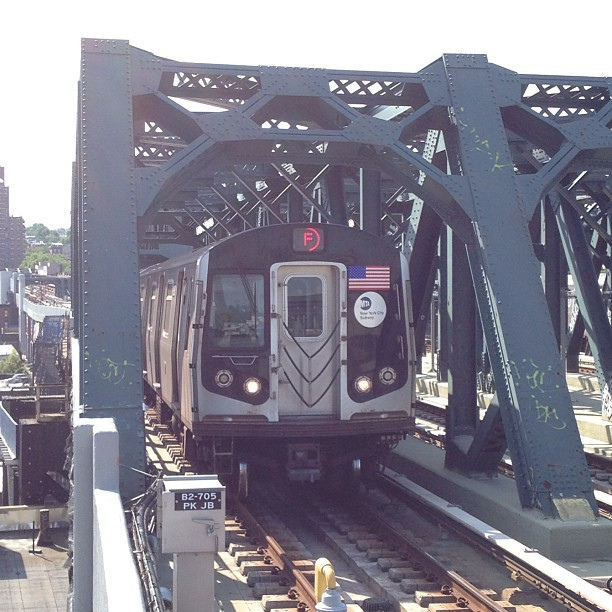

In [4]:
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

## Prepair the models

In [5]:
image_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [6]:
# freeze layers
for layer in image_features_extract_model.layers[:]:
    layer.trainable = False

In [7]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img) #Kernal dies here :D
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 313/313 [01:28<00:00,  3.54it/s]


In [9]:
word_to_index, index_to_word, tokenizer, cap_vector = tokenization(train_captions, max_length, vocabulary_size)

In [10]:
img_name_train, cap_train, img_name_val, cap_val = split_data(img_name_vector, cap_vector,percentage)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(47520, 47520, 2503, 2503)

In [11]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

# Training parameters
epochs = 40
num_steps = len(img_name_train) // BATCH_SIZE

In [12]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Making the models

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

## Training

In [14]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [15]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [16]:
train_RNN(epochs, start_epoch, ckpt_manager, num_steps,
              dataset, decoder, encoder, word_to_index)

Epoch 1 Batch 0 Loss 6.8981
Epoch 1 Batch 100 Loss 4.1088
Epoch 1 Batch 200 Loss 3.5354
Epoch 1 Batch 300 Loss 3.2599
Epoch 1 Batch 400 Loss 2.9201
Epoch 1 Batch 500 Loss 2.8584
Epoch 1 Batch 600 Loss 2.7714
Epoch 1 Batch 700 Loss 2.6866
Epoch 1 Loss 3.328715
Time taken for 1 epoch 94.84 sec

Epoch 2 Batch 0 Loss 2.5855
Epoch 2 Batch 100 Loss 2.5498
Epoch 2 Batch 200 Loss 2.5090
Epoch 2 Batch 300 Loss 2.6565
Epoch 2 Batch 400 Loss 2.4950
Epoch 2 Batch 500 Loss 2.4717
Epoch 2 Batch 600 Loss 2.3573
Epoch 2 Batch 700 Loss 2.4301
Epoch 2 Loss 2.496645
Time taken for 1 epoch 48.56 sec

Epoch 3 Batch 0 Loss 2.3282
Epoch 3 Batch 100 Loss 2.2863
Epoch 3 Batch 200 Loss 2.1775
Epoch 3 Batch 300 Loss 2.4506
Epoch 3 Batch 400 Loss 2.1758
Epoch 3 Batch 500 Loss 2.4030
Epoch 3 Batch 600 Loss 2.1760
Epoch 3 Batch 700 Loss 2.1851
Epoch 3 Loss 2.223959
Time taken for 1 epoch 54.01 sec

Epoch 4 Batch 0 Loss 1.8927
Epoch 4 Batch 100 Loss 1.9756
Epoch 4 Batch 200 Loss 1.9291
Epoch 4 Batch 300 Loss 2.0426


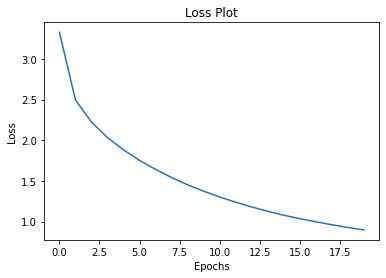

In [17]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Result

Real Caption: <start> saltine crackers lay next to a wedge of cheese, with grapes and other items
Prediction Caption: a pile of food are displayed on the table. <end>


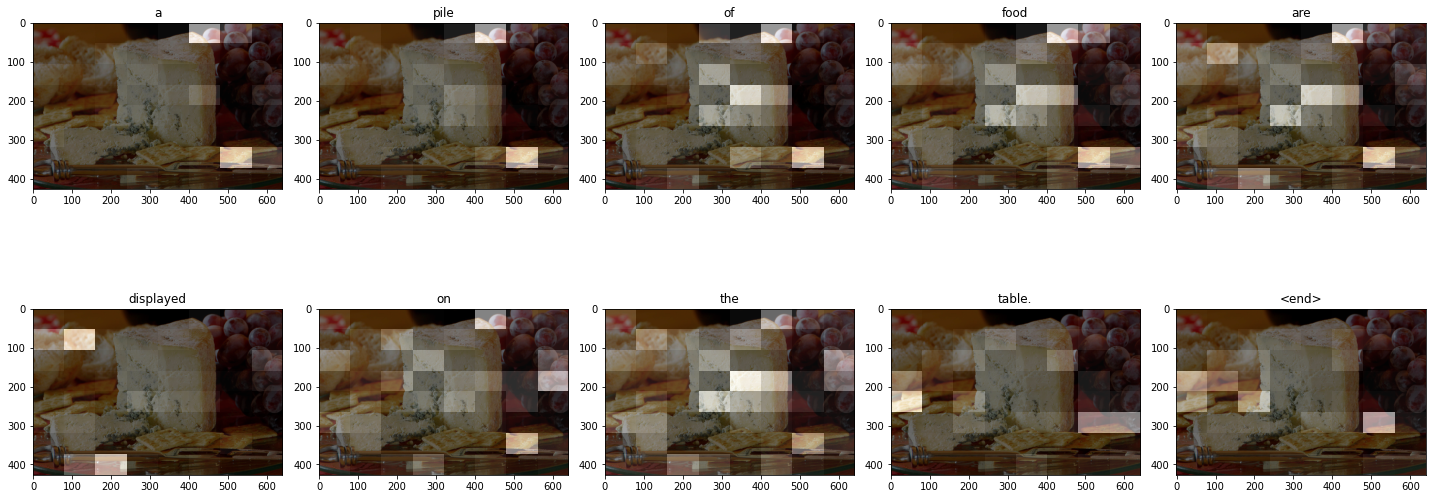

In [20]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, max_length, attention_features_shape, encoder, decoder,
             image_features_extract_model, word_to_index, index_to_word)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> the two young children are sitting at the table together. <end>
Prediction Caption: a little girl sitting in one of a piece of pizza. <end>


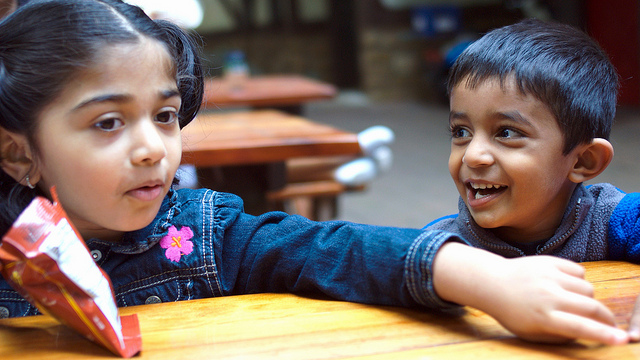

In [31]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
                         
result = predict(image, encoder, decoder,
            image_features_extract_model, max_length,
            word_to_index, index_to_word)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)